In [1]:
import numpy as np
from IPython.display import clear_output, display, Image, Audio
import torch
import torch.nn as nn
import librosa
import PIL.Image
import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from io import BytesIO
from skorch.net import NeuralNet
from functools import partial
from model import Classifier
from torchvision.models import inception_v3

In [2]:
classifier = Classifier(2)
# classifier = inception_v3(pretrained=True, transform_input=True)
net = NeuralNet(classifier, nn.CrossEntropyLoss)
net.initialize()
net.load_params(f_params="models/without_phase//params.pt")
layers_outputs = {}
classifier.eval()

def register_layer_output(module, input_, output, layer_name):
    layers_outputs[layer_name] = output

# current_register = partial(register_layer_output, layer_name="mixed_5d")
# classifier.Mixed_5d.register_forward_hook(current_register)
for layer_name, layer in classifier.layers_blocks.items():
    if "residual" in layer_name:
        current_register = partial(register_layer_output, layer_name=layer_name)
        layer.register_forward_hook(current_register)
#         layer.register_forward_hook(current_register)

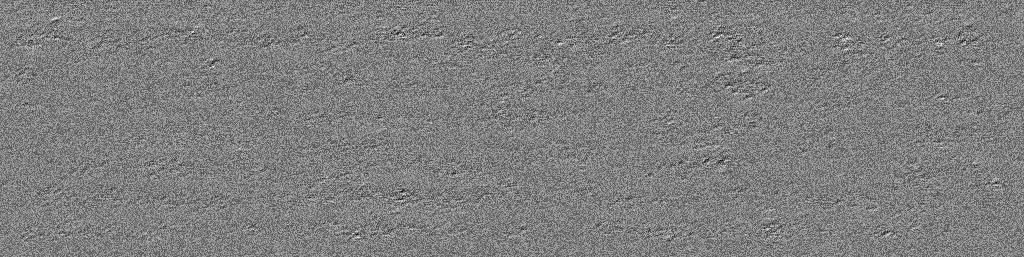

In [3]:
img_noise = np.random.uniform(-127.5, 127.5, size=(257,1024,1))

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def render_naive(img0=img_noise, iter_n=20, step=1.5):
    img = img0.copy()
    img = torch.from_numpy(img).float()
    img = img.permute((2, 0, 1))
    img.requires_grad = True
    optimizer = optim.Adam([img], lr=step)

    for i in range(iter_n):
#         optimizer.zero_grad()
        img.requires_grad = True
        classifier(img[None])
#         out = layers_outputs["mixed_5d"][0, 8]
        out = layers_outputs["residual_4a"][0, 4]
        score = out.mean()
        score.backward()
        g = img.grad.detach()
        g /= g.abs().mean() + 1e-8
        img.requires_grad = False
        img += g
#         optimizer.step()
        
        clear_output()
        print("Step: {}".format(i), score, end=' ')
        showarray(visstd(img[0].detach().numpy()))
    clear_output()
    
    img /= img.max()
    showarray(visstd(img[0].detach().numpy()))

render_naive()

In [4]:
from pytorch_extensions import roll

def calc_grad_tiled(model, stft: torch.Tensor, tile_size: int = 128) -> torch.Tensor:
    h, w = stft.shape[1:]
    sx, sy = np.random.randint(5, size=2)
    stft_shift = roll(roll(stft, sx, axis=2), sy, axis=1)
    grads = torch.zeros_like(stft)
    for y in range(0, max(h - tile_size // 2, tile_size), tile_size):
        for x in range(0, max(w - tile_size // 2, tile_size), tile_size):
            frame = stft_shift[:, y:y + tile_size, x:x + tile_size]
            frame.requires_grad = True
            model(frame[None])

            layer_output = layers_outputs["residual_4a"][0, 4]
            objective_output = layer_output.mean()
            objective_output.backward()

            frame.requires_grad = False
            grad = frame.grad.detach().clone()
            grads[:, y:y + tile_size, x:x + tile_size] = grad
    result = roll(roll(grads, -sx, axis=2), -sy, axis=1)
    return result

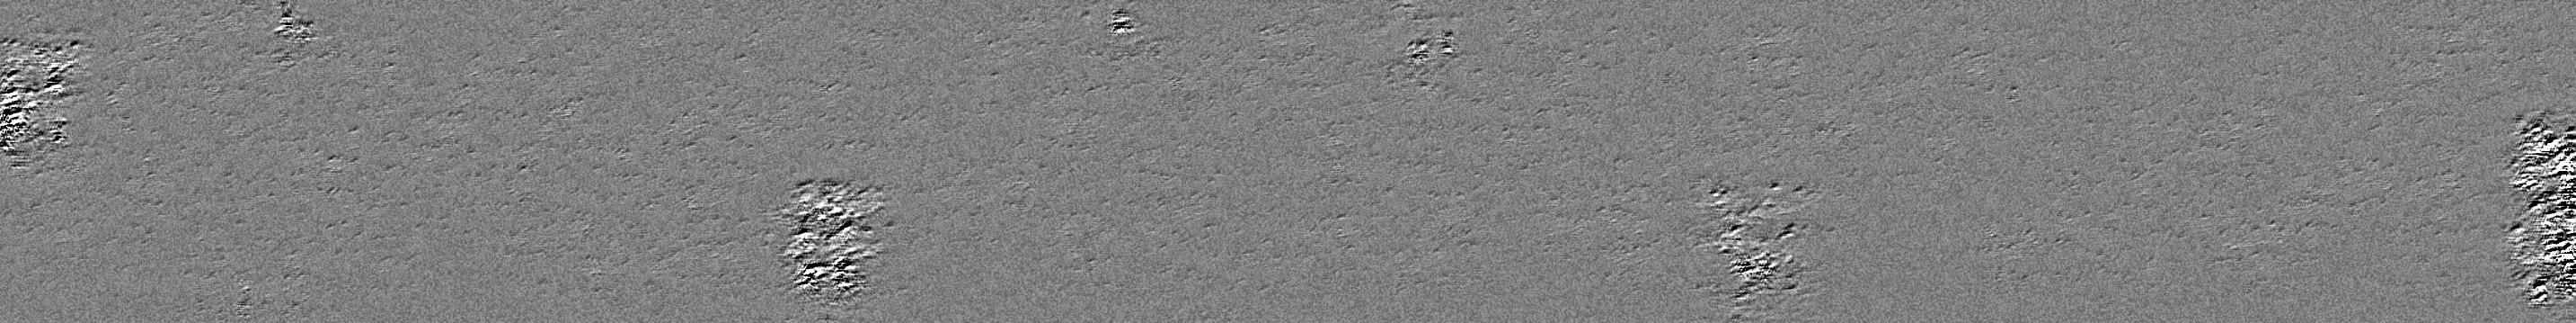

(359, 2867, 1)


In [5]:
img_noise = np.random.uniform(-127.5, 127.5, size=(257,2048,1))

def render_multiscale(img0=img_noise, iter_n=20, step=2, octave_n=3, octave_scale=1.4):
    
    img = img0.copy()
    for octave in range(octave_n):
        print(img.shape)
        if octave > 0:
            hw = np.float32(img.shape[:2]) * octave_scale
            img = cv2.resize(img, tuple(np.int32(hw[::-1])))
            img = img[..., None]
        
        img = torch.from_numpy(img).float()
        print(img.shape)
        img = img.permute((2, 0, 1))
        img.requires_grad = True
#         optimizer = optim.Adam([img], lr=step)
        for i in range(iter_n):
#             optimizer.zero_grad()
            img.requires_grad = True
            classifier(img[None])
    #         out = layers_outputs["mixed_5d"][0, 8]
            out = layers_outputs["residual_4b"][0, 2]
#             out = out * (torch.log(out + 2) < 0.3 * torch.max(out + 2)).float()
            score = out.mean()
            score.backward()
            g = img.grad.detach()
            g /= g.abs().mean() + 1e-8
            g *= step
            img.requires_grad = False
            img += g
#             optimizer.step()

            clear_output()
            print("Step: {}".format(i), score, end=' ')
            showarray(visstd(img[0].detach().numpy()))
        clear_output()

        showarray(visstd(img[0].detach().numpy()))
        img = img.detach().numpy().transpose((1, 2, 0))
        print(img.shape)
    return img

an_img = render_multiscale(iter_n=10, octave_n=2)

In [25]:
def calc_grad_tiled(model, stft: torch.Tensor, tile_size: int = 128) -> torch.Tensor:
    h, w = stft.shape[1:]
    sx, sy = np.random.randint(tile_size, size=2)
    stft_shift = roll(roll(stft, sx, axis=2), sy, axis=1)
    grads = torch.zeros_like(stft)
    for y in range(0, max(h - tile_size // 2, tile_size), tile_size):
        for x in range(0, max(w - tile_size // 2, tile_size), tile_size):
            frame = stft_shift[:, y:y + tile_size, x:x + tile_size]
            frame.requires_grad = True
            model(frame[None])

            out = layers_outputs["residual_1a"][0, 6]
            objective_output = out.mean()
            objective_output.backward()

            frame.requires_grad = False
            grad = frame.grad.detach().clone()
            grads[:, y:y + tile_size, x:x + tile_size] = grad
    result = roll(roll(grads, -sx, axis=2), -sy, axis=1)
    return result

def render_deepdream(img0=img_noise,
                     iter_n=10, step=1.5, octave_n=16, octave_scale=1.4):
    # split the image into a number of octaves
    img = img0.copy()
    print(img.mean())
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = cv2.resize(img, tuple(np.int32(np.float32(hw[::-1])/octave_scale)))[..., None]
        hi = img - cv2.resize(lo, tuple(np.int32(hw[::-1])))[..., None]
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        print(img.mean())
        if octave>0:
            hi = octaves[-octave]
            img = cv2.resize(img, tuple(np.int32(hi.shape[:2][::-1])))[..., None] + hi
        
        img = torch.from_numpy(img).float()
        img = img.permute((2, 0, 1))
        
        for i in range(iter_n):
            g = calc_grad_tiled(classifier, img)
            g /= (g.abs().mean() + 1e-8)
            g *= step
            img += g 
            clear_output()
            print("Step: {}".format(i), end=' ')
            showarray(visstd(img[0].detach().numpy()))
        clear_output()
        showarray(visstd(img[0].detach().numpy()))
        img = img.detach().numpy().transpose((1, 2, 0))
    print(img.mean())
    return img


In [26]:
y, sr = librosa.load('audio/1089-134686-0000.flac', sr=44100)
# y, sr = librosa.load('audio/song.mp3', sr=44100)
# y = y[44100*5:44100*10]
# y = y[44100*20:44100*25]
win_len = 512
n_fft = win_len
y_stft = librosa.core.stft(y, n_fft=n_fft, win_length=win_len)

y_stft_mag1, y_stft_ang = librosa.magphase(y_stft)
print(y_stft_mag1.mean())

nonlin = 1.0/8.0
y_stft_mag = np.power(y_stft_mag1, nonlin)
a_max = y_stft_mag.max()
y_stft_mag = np.flipud((1 - y_stft_mag / y_stft_mag.max())) * 255 - 127.5
y_stft_mag = y_stft_mag[..., None]
print(y_stft_mag.mean())
y_stft_mag.shape

0.09432344
74.71383


(257, 3596, 1)

In [27]:
y_stft_mag1.min()

7.363554e-14

In [28]:
Audio(y, rate=44100)

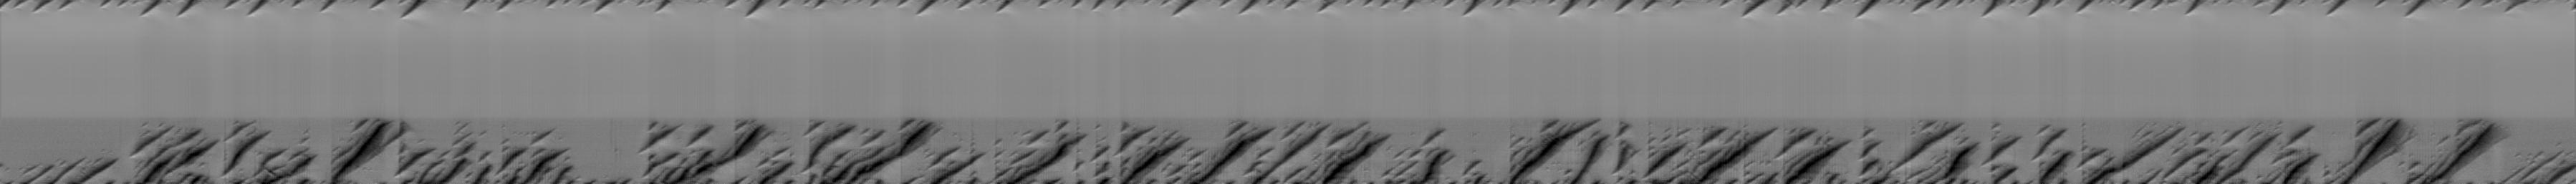

65.74158


In [29]:
an_img = render_deepdream(y_stft_mag, iter_n=10, octave_n=10, step=0.6)

In [11]:
an_img.min(), an_img.max(), an_img.mean()

(-474.37662, 287.15225, 65.724495)

In [12]:
stft = an_img

stft = np.flipud(stft)[..., 0]
stft = (stft + 127.5)
out = (1 - stft / stft.max()) * a_max
out = np.power(out, 1 / nonlin)

stft = out * y_stft_ang
unfouriered = librosa.istft(stft, win_length=win_len)
unfouriered = ((unfouriered - unfouriered.min()) / (unfouriered.max() - unfouriered.min()) - 0.5) * 8
unfouriered = np.clip(unfouriered, -1, 1)
Audio(unfouriered, rate=44100, normalize=True)